In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


In [2]:
data = pd.read_excel('Predict_student_ knowledge_level.xls')

In [3]:
data.columns = [col.strip() for col in data.columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     403 non-null    float64
 1   SCG     403 non-null    float64
 2   STR     403 non-null    float64
 3   LPR     403 non-null    float64
 4   PEG     403 non-null    float64
 5   UNS     403 non-null    object 
dtypes: float64(5), object(1)
memory usage: 19.0+ KB


# check for null values

In [5]:
data.isna().sum() # no null values

STG    0
SCG    0
STR    0
LPR    0
PEG    0
UNS    0
dtype: int64

# Describe data

In [6]:
data.describe() # it doesnt seem that data cotains non tipycal values

,STG,SCG,STR,LPR,PEG
count,403.000000,403.000000,403.000000,403.000000,403.000000
mean,0.353141,0.355940,0.457655,0.431342,0.456360
std,0.212018,0.215531,0.246684,0.257545,0.266775
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.265000,0.250000,0.250000
50%,0.300000,0.300000,0.440000,0.330000,0.400000
75%,0.480000,0.510000,0.680000,0.650000,0.660000
max,0.990000,0.900000,0.950000,0.990000,0.990000


# Check for Balance in Target variable

In [7]:
data['UNS'].value_counts() # we gotta standarize names

UNS
Low         129
Middle      122
High        102
Very Low     26
very_low     24
Name: count, dtype: int64

In [8]:
data['UNS'] = np.where(data['UNS'] == "Very Low", "very_low", data['UNS']) # if category = "Very Low" then return "very_low", else return category

In [9]:
data['UNS'].value_counts(normalize = True) # data is kind of umbalanced but not that much, lets see if it bais results

UNS
Low         0.320099
Middle      0.302730
High        0.253102
very_low    0.124069
Name: proportion, dtype: float64

# Data Analysis

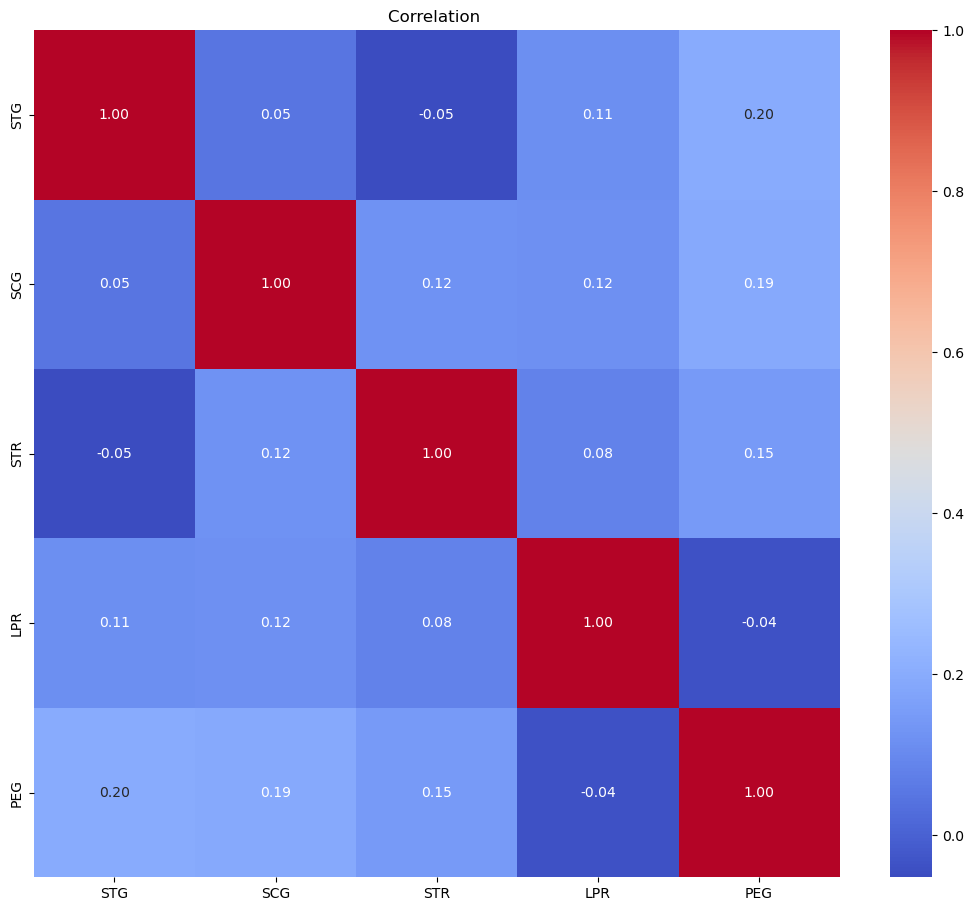

In [10]:
fig = plt.figure(figsize=(13,11))
r = sns.heatmap(data.drop(columns = ['UNS']).corr(),annot = True,fmt= ".2f", cmap = 'coolwarm')
r.set_title("Correlation ")
plt.show()

In [23]:
data

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low
...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,High
399,0.85,0.82,0.66,0.83,0.83,High
400,0.56,0.60,0.77,0.13,0.32,Low
401,0.66,0.68,0.81,0.57,0.57,Middle


Text(0.5, 1.0, 'Count of UNS classes')

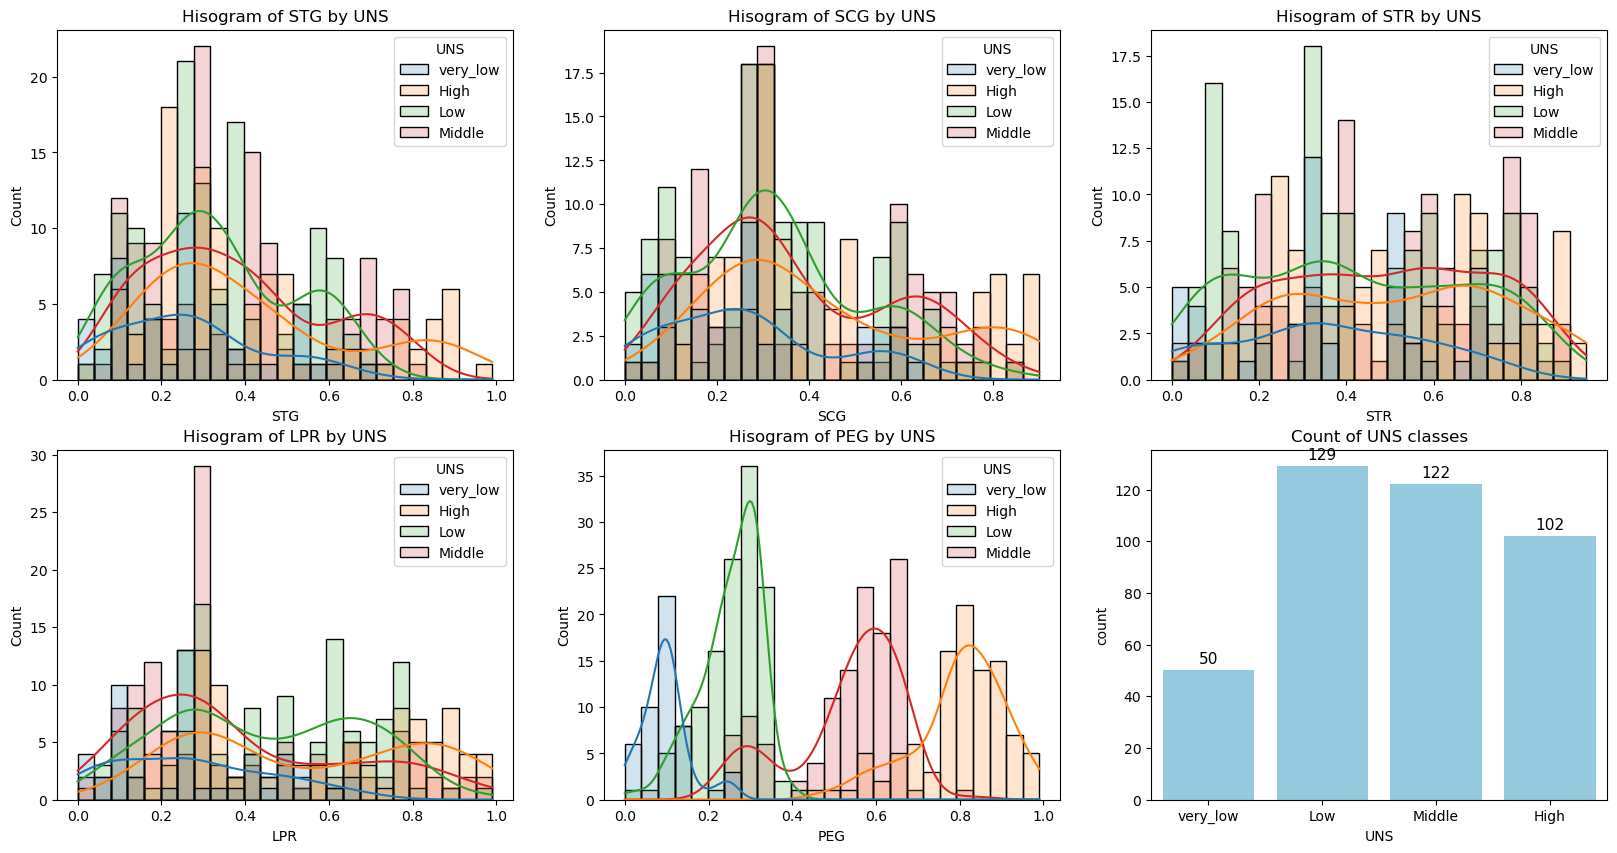

In [56]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))

sns.histplot(x = "STG", data = data, hue = "UNS", alpha = 0.2, kde = True, ax = ax[0, 0], bins = 25)
ax[0,0].set_title("Hisogram of STG by UNS")

sns.histplot(x = "SCG", data = data, hue = "UNS", alpha = 0.2, kde = True, ax = ax[0, 1], bins = 25)
ax[0,1].set_title("Hisogram of SCG by UNS")

sns.histplot(x = "STR", data = data, hue = "UNS", alpha = 0.2, kde = True, ax = ax[0, 2], bins = 25)
ax[0,2].set_title("Hisogram of STR by UNS")

sns.histplot(x = "LPR", data = data, hue = "UNS", alpha = 0.2, kde = True, ax = ax[1, 0], bins = 25)
ax[1,0].set_title("Hisogram of LPR by UNS")

sns.histplot(x = "PEG", data = data, hue = "UNS", alpha = 0.2, kde = True, ax = ax[1, 1], bins = 25)
ax[1,1].set_title("Hisogram of PEG by UNS")

sns.countplot(x='UNS', data=data, order=["very_low", "Low", "Middle", "High"], color = "skyblue", ax = ax[1, 2])
for p in ax[1, 2].patches:
    ax[1, 2].annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')
ax[1,2].set_title("Count of UNS classes")

# Outlier detection

In [51]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [53]:
detect_outliers(data,["PEG","LPR","STR","SCG","STG"])  # there is no outliers

[]

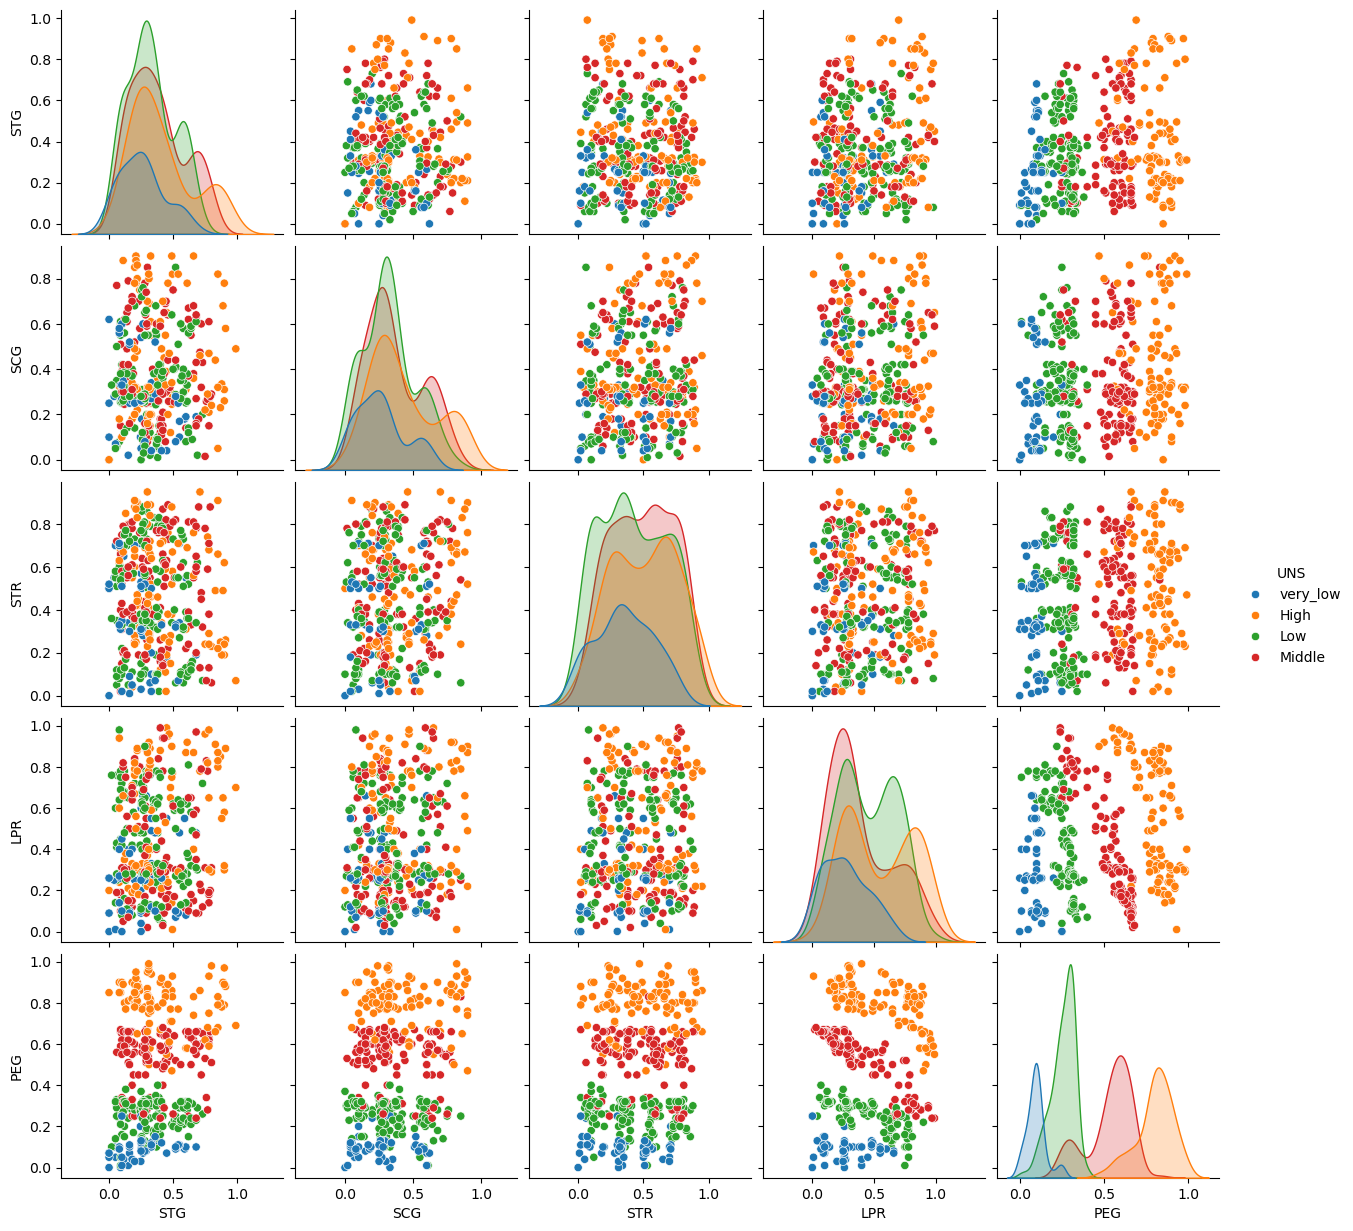

In [57]:
sns.pairplot(data, hue = 'UNS')

# Oversample

In [85]:
x = data.drop(columns = ['UNS'])
y = data['UNS']

In [86]:
oversample = SMOTENC(categorical_features= [1])
X, Y = oversample.fit_resample(x, y)

# Processing

In [88]:
le = LabelEncoder()
y_encoded = list(le.fit_transform(Y))

In [91]:
le.inverse_transform([0,1,2, 3])

array(['High', 'Low', 'Middle', 'very_low'], dtype=object)

# Traint - Test Split

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X,y_encoded,test_size = 0.20,random_state = 42)

# Models

## Support Vector Machines

Train Score:  0.9781553398058253
Test Score:  0.9615384615384616


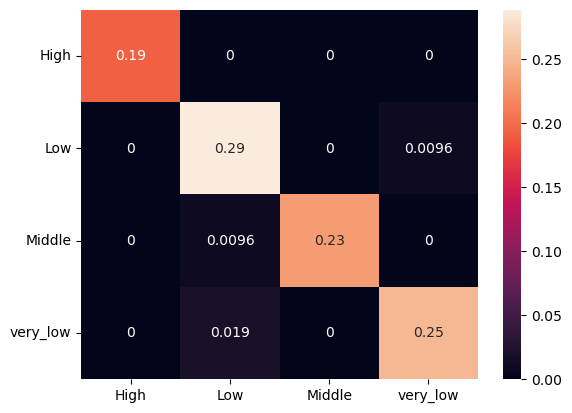

In [99]:
modelSVC = SVC(random_state = 42).fit(X_train,y_train)
preds_SVC = modelSVC.predict(X_test)
print("Train Score: ",modelSVC.score(X_train,y_train))
print("Test Score: ",modelSVC.score(X_test,y_test))
cmSVC = confusion_matrix(y_test,preds_SVC, normalize = "all")
sns.heatmap(cmSVC,annot = True,xticklabels= le.inverse_transform([0,1,2, 3]),yticklabels = le.inverse_transform([0,1,2, 3]))
plt.yticks(rotation = 0)
plt.show()

## RandomForest Classifier

Train Score:  1.0
Test Score:  0.9519230769230769


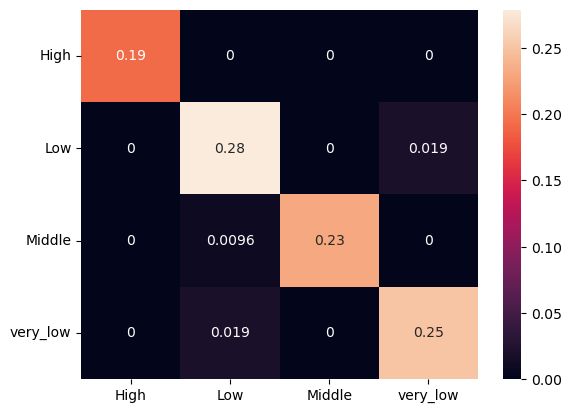

In [104]:
modelRFC = RandomForestClassifier(random_state = 42).fit(X_train,y_train)
preds_RFC = modelRFC.predict(X_test)
print("Train Score: ",modelRFC.score(X_train,y_train))
print("Test Score: ",modelRFC.score(X_test,y_test))
cmRFC = confusion_matrix(y_test,preds_RFC, normalize = "all")
sns.heatmap(cmRFC,annot = True,xticklabels= le.inverse_transform([0,1,2, 3]),yticklabels = le.inverse_transform([0,1,2, 3]))
plt.yticks(rotation = 0)
plt.show()

## XGBoost Classifier

Train Score:  1.0
Test Score:  0.9711538461538461


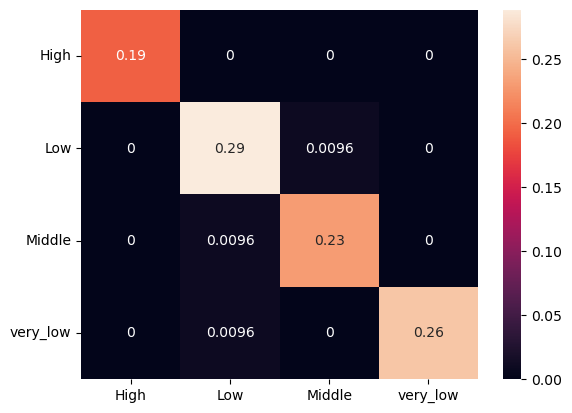

In [105]:
modelXGB = XGBClassifier(random_state = 42).fit(X_train,y_train)
preds_XGB = modelXGB.predict(X_test)
print("Train Score: ",modelXGB.score(X_train,y_train))
print("Test Score: ",modelXGB.score(X_test,y_test))
cmXGB = confusion_matrix(y_test,preds_XGB, normalize = "all")
sns.heatmap(cmXGB,annot = True,xticklabels= le.inverse_transform([0,1,2, 3]),yticklabels = le.inverse_transform([0,1,2, 3]))
plt.yticks(rotation = 0)
plt.show()

# Auto ML

In [107]:
from flaml import AutoML

In [111]:
automl = AutoML()

In [112]:
automl_settings = {
    "time_budget": 60,  # time in seconds
    "metric": 'accuracy',  # metric to optimize
    "task": 'classification'  # task type
}

In [116]:
automl.fit(X_train=X_train, y_train=pd.Series(y_train), **automl_settings)

[flaml.automl.logger: 09-04 22:17:58] {1680} INFO - task = classification
[flaml.automl.logger: 09-04 22:17:58] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 09-04 22:17:58] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 09-04 22:17:58] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 09-04 22:17:58] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-04 22:17:58] {2345} INFO - Estimated sufficient time budget=866s. Estimated necessary time budget=20s.
[flaml.automl.logger: 09-04 22:17:58] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.1408,	best estimator lgbm's best error=0.1408
[flaml.automl.logger: 09-04 22:17:58] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-04 22:17:59] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1408,	best estimator lgbm's best error=0.1408
[flaml.automl.logger: 09-04 22:17:5

C:\Users\Jose\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9805825242718447
0.9230769230769231


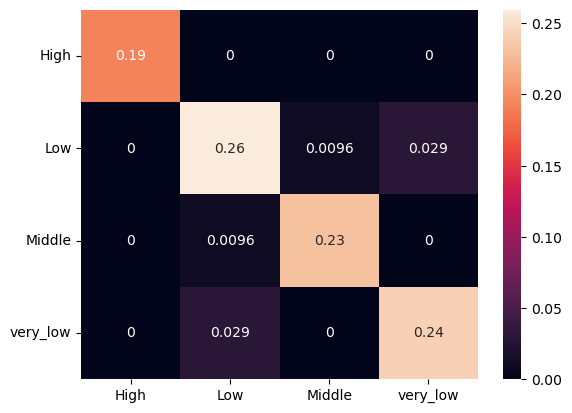

In [120]:
Preds = automl.predict(X_test)
print(automl.score(X_train, pd.Series(y_train)))
print(automl.score(X_test, pd.Series(y_test)))
cmML = confusion_matrix(pd.Series(y_test),automl.predict(X_test), normalize = 'all')
sns.heatmap(cmML,annot = True,xticklabels= le.inverse_transform([0,1,2, 3]),yticklabels = le.inverse_transform([0,1,2, 3]))
plt.yticks(rotation = 0)
plt.show()